In [21]:
#batch norm removed, dropout probability to 0.5
#dropout added to fc  not good

#remove vectors after 4096 to be similar to paper, sigmoid is added to each out put, still keep the contrast loss
#modify the net, sigmoid on out put of the outpu1-output2, then get to the 1*1 then,cross entropy

#decided to get the dropout to 0.2, 0.5 not working, kept batch norm, using sigmoid as original paper and droppping the dimensions to 
# 4096 and the 1 with sigmoid and using absolute distance not worked (with BCE losss)

#using contrast loss but kept all 4096 for now as inout to loss,  


#had to go back keep to 4096 to 5 (need definitely batch norm), question put dropout in fc? margin impact now with 2.0

#margin 5 or 1 did not work out just running it longer 200 epochs

#added dropout (0.2) for fc not bad, does it need more than 200 or higher dropout probability?

# test loader option with a flag is added to get if needed same probability of classes as second image or accuracy calculation

#model is also saved

#for omniglot images are png, had trouble opening with PIL (with imshow was all black), used cv2 and array, only tranformed
#using tensor since other trasnforms needed PIL!!!! annoying. per language brough one alphabet and ~20 instances per alphabet

#after reloading the model had to be tested as none cude since weights not saved with cuda!


import numpy as np
import torch
from torch import nn
import torch.functional as F
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms,utils, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
from PIL import Image
import cv2


In [22]:
test=[]
test2=[]
for i in range(1000):
    test.append(np.random.randint(2))
    test2.append(np.random.randint(0,1))


In [23]:
np.mean(test)

0.52400000000000002

In [24]:
np.mean(test2)

0.0

In [25]:

class att_dataset(Dataset):
    
    def __init__(self,main_dir,data_transorm,flag_train):
        
        #self.train_dir=main_dir+'train/'
        #self.test_dir=main_dir+'test/'
        self.main_dir_=main_dir
        self.data_transform=data_transorm
        self.flag_train=flag_train

        #self.trainset = datasets.ImageFolder(self.train_dir, transform=data_transform)
        self.mainset = datasets.ImageFolder(self.main_dir_)
        self.len=len(list(self.mainset.imgs))   #self.trainset.imgs gives tuples
        #print(self.len)
        self.classes=list(self.mainset.classes)
        self.len_classes=len(self.classes)
        print(len(self.classes))
        
        #testset = datasets.ImageFolder(self.test_dir, transform=data_transform)

                      
    def __getitem__(self,index):
        
        #indx1 = np.random.choice(len(self.mainset.imgs))
        #img1=self.mainset.imgs[indx1]  #tuple first image
        #print(img1)
        
        
        #make 50% 
        if(self.flag_train):
            
            indx1 = np.random.choice(len(self.mainset.imgs))
            img1=self.mainset.imgs[indx1]  #tuple first image

            random_gen=np.random.randint(2)

            while True:   

                index2 = np.random.choice(len(self.mainset.imgs))
                img2=self.mainset.imgs[index2]

                if ((img1[1]==img2[1]) and (random_gen==1)):   #label checking
                    indx2=index2
                    img2=img2

                    break

                if ((img1[1]!=img2[1]) and (random_gen==0)):   #label checking
                    indx2=index2
                    img2=img2

                    break 
                    
        else:
            
            indx1 = np.random.choice(len(self.mainset.imgs))
            img1=self.mainset.imgs[indx1]  #tuple first image
            
            random_gen_class=np.random.choice(len(self.mainset.imgs))
            img2=self.mainset.imgs[random_gen_class]   #want to make sure if pick 1st image for testing 2nd image coming from random classes
            if((img1[1]!=img2[1])): 
                random_gen=0
            else: 
                random_gen=1
            
            
                
        #img0_ = Image.open(img1[0])
        #img1_ = Image.open(img2[0])
        
        img0_=cv2.imread(img1[0],0)
        img1_=cv2.imread(img2[0],0)
        
        #img0_.load()
        img0_ = np.asarray( img0_, dtype="int32" )
        #print(img0_.shape)
        img0_=np.reshape(img0_,(img0_.shape[0],img0_.shape[1],1))
        #print(img0_.shape)

        #img1_.load()
        img1_ = np.asarray( img1_, dtype="int32" )
        img1_=np.reshape(img1_,(img1_.shape[0],img1_.shape[1],1))
        
        img0_ = self.data_transform(img0_)
        img1_ = self.data_transform(img1_)
        

                
                
        return img0_,img1_,torch.from_numpy(np.array([random_gen],dtype=np.float32))
                  
    
    def __len__(self):
                       
        return self.len
    
    

                                                
                                                
# TODO: Using the image datasets and the trainforms, define the dataloaders


#test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)     

In [26]:
for i in range(10):
    print(np.random.choice(10))

8
1
4
4
7
1
6
7
1
9


In [27]:
main_dir='omniglot/train_/'
#train_dir=main_dir+'train/'
#test_dir=main_dir+'test/'
batch_size=128

#data_transform_train = transforms.Compose([transforms.Resize(112),transforms.RandomRotation([-30,30]),
#         transforms.CenterCrop(105),transforms.RandomHorizontalFlip(),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))

data_transform_train=transforms.Compose([transforms.ToTensor()]) 
data_transform_test=transforms.Compose([transforms.ToTensor()]) 
dataset_att=att_dataset(main_dir=main_dir,data_transorm=data_transform_train,flag_train=True)
train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=batch_size,shuffle=True)

#data_transform_test = transforms.Compose([transforms.Resize(112),
#         transforms.CenterCrop(105),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))
dataset_att2=att_dataset(main_dir='omniglot/test_/',data_transorm=data_transform_train,flag_train=False)
test_loader = torch.utils.data.DataLoader(dataset_att2, batch_size=batch_size,shuffle=True)

965
659


In [28]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

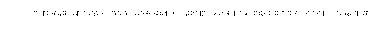

[[ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]]


In [29]:
example_batch = next(iter(train_loader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=batch_size))
print(example_batch[2].numpy())
#plt.imshow(example_batch[0])



In [30]:
# example_batch = next(iter(test_loader))
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated,nrow=batch_size))
# print(example_batch[2].numpy())

In [31]:
# image,label=next(iter(train_loader))
# print(image.size())
# print(label.size())
# for i in range(5):
    
#     plt.imshow(image[i][0])
#     plt.show

In [32]:
class simese_network(nn.Module):
    def __init__(self):
        super(simese_network,self).__init__()
        
        self.conv1=nn.Conv2d(1,64,kernel_size=10)   # (105-10-0)/1 +1=96     96*96*64 
        self.relu1=nn.ReLU()                        #                        96*96*64
        self.maxpool1=nn.MaxPool2d(kernel_size=2)   #                        48*48 *64
        self.batchnorm1=nn.BatchNorm2d(64)
        #self.dropout1=nn.Dropout2d(p=0.2)
        
        self.conv2=nn.Conv2d(64,128,kernel_size=7)  #  (48-7-0)/1+1= 42     42*42*128
        self.relu2=nn.ReLU()                        #                       42*42*128
        self.maxpool2=nn.MaxPool2d(kernel_size=2)   #                       21*21*128
        self.batchnorm2=nn.BatchNorm2d(128)
        #self.dropout2=nn.Dropout2d(p=0.2)
        
        self.conv3=nn.Conv2d(128,128,kernel_size=4) # (21-4-0)/1+1= 18     18*18*128
        self.relu3=nn.ReLU()                        #                      18*18*128
        self.maxpool3=nn.MaxPool2d(kernel_size=2)   #                      9*9*128
        self.batchnorm3=nn.BatchNorm2d(128)
        #self.dropout3=nn.Dropout2d(p=0.2)
        
        self.conv4=nn.Conv2d(128,256,kernel_size=4) # (9-4-0)/1+1=6       6*6*256 
        self.relu4=nn.ReLU() 
        self.batchnorm4=nn.BatchNorm2d(256)
        #self.dropout4=nn.Dropout2d(p=0.2)
        
        self.linear1=nn.Linear(9216,4096)  
        self.linear2=nn.Linear(4096,1) 
        
        #self.relu5=nn.ReLU()
        #self.dropout5=nn.Dropout(p=0.2)
        
        #self.linear2=nn.Linear(4096,512)
        #self.relu6=nn.ReLU()
        #self.dropout6=nn.Dropout(p=0.2)
        
        #self.linear3=nn.Linear(512,10)
        #self.relu7=nn.ReLU()  
        #self.dropout7=nn.Dropout(p=0.2)
        
        #self.linear4=nn.Linear(10,5)       
        
        
        

    def forward_main(self,x):
        
        self.in_channel_batch=x.size(0)
        
        x=(self.batchnorm1(self.maxpool1(self.relu1(self.conv1(x)))))
              
        x=(self.batchnorm2(self.maxpool2(self.relu2(self.conv2(x)))))
        
        x=(self.batchnorm3(self.maxpool3(self.relu3(self.conv3(x)))))
        
        x=(self.batchnorm4(self.relu4(self.conv4(x))))
        
        x=x.view(self.in_channel_batch,-1)  #batch batch size* -1,  
        
        
        x=F.sigmoid(self.linear1(x))
        
        #x=self.dropout5(self.relu5(self.linear1(x)))
        #x=self.dropout6(self.relu6(self.linear2(x)))       
        #x=self.dropout7(self.relu7(self.linear3(x)))
        
        #x=self.linear4(x)
        
        #output=F.sigmoid(x)
        
        output=x
        
        return output
    
    
    def forward(self,x1,x2):
        
        output1=self.forward_main(x1)
        output2=self.forward_main(x2)
        
        output_=F.l1_loss(output1,output2,size_average=False,reduce=False)  #abs distance between 4096 vector, keep all batches
        
        x=(self.linear2(output_)) #take the out put sigmoid into BCElosslogit which said to be more stable
        
        output=x   # batch size goes out
        

        
        return output
        
    
    
    

In [33]:

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


In [34]:
model=simese_network()

In [35]:
epochs=100
#criterion=ContrastiveLoss()  
criterion=torch.nn.BCEWithLogitsLoss(size_average=False)
#criterion=torch.nn.BCELoss(size_average=True)
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)  #had to change from SGD to Adam but later noy much difference

lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [36]:
within_run_loss=[]
step_=[]
avg_loss_=[]
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0
    
    model.to(device)

    for epoch in range(epochs):

        for step,(img1,img2,labels) in enumerate(train_loader):
            
            
            
            img1=img1.to(device)
            img2=img2.to(device)
            labels=labels.to(device)
            #print(labels)
            optimizer.zero_grad()
            #input.resize_(input.size()[0], 784)   take to forward
            output=model(img1,img2)   #this is 64 (bacth_size)*10
            
            #if(count==0): print(y_pred.size(),labels.size())
            loss=criterion(output,labels)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(labels.size()[0])
            #_,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            #acc=(labels==y_pred_).sum().item()    #/label.size()[0]
            #sum_acc=sum_acc+acc
            #print(count)
            #print(step)
            if(step%100==0): 
                
                print('epoch',epoch+1,'/',epochs,'avg train running_loss:',(loss_running/count_batch),'within run loss',loss.item())  #,'Accuracy',(sum_acc*100/count_batch))
                within_run_loss.append(loss.item())
                #step_=[]
                avg_loss_.append(loss_running/count_batch)
                print('-----')
                #test_function(test_loader)
                #print('---------------------')
                #model.train()
            
        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)



In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_function(train_loader)

cuda
epoch 1 / 100 avg train running_loss: 0.6903606653213501 within run loss 88.36616516113281
-----
epoch 1 / 100 avg train running_loss: 0.45058682855993215 within run loss 45.06253433227539
-----
epoch 2 / 100 avg train running_loss: 0.40817603294454324 within run loss 50.526119232177734
-----
epoch 2 / 100 avg train running_loss: 0.35518311334970987 within run loss 37.12989807128906
-----
epoch 3 / 100 avg train running_loss: 0.33611226219890333 within run loss 37.15271759033203
-----
epoch 3 / 100 avg train running_loss: 0.30920483315487396 within run loss 23.049596786499023
-----
epoch 4 / 100 avg train running_loss: 0.29781005703675756 within run loss 30.145532608032227
-----
epoch 4 / 100 avg train running_loss: 0.27978349843770167 within run loss 24.9000186920166
-----
epoch 5 / 100 avg train running_loss: 0.27180637662432466 within run loss 31.939651489257812
-----
epoch 5 / 100 avg train running_loss: 0.2557187772275881 within run loss 13.731420516967773
-----
epoch 6 / 100

epoch 42 / 100 avg train running_loss: 0.08974098410391566 within run loss 1.9593108892440796
-----
epoch 43 / 100 avg train running_loss: 0.08932689834154871 within run loss 1.0734349489212036
-----
epoch 43 / 100 avg train running_loss: 0.08857688877633463 within run loss 4.253737449645996
-----
epoch 44 / 100 avg train running_loss: 0.08819978933095532 within run loss 1.7804081439971924
-----
epoch 44 / 100 avg train running_loss: 0.08747942963880849 within run loss 4.519792556762695
-----
epoch 45 / 100 avg train running_loss: 0.08711372376468429 within run loss 1.5758330821990967
-----
epoch 45 / 100 avg train running_loss: 0.08640938735928087 within run loss 5.2223992347717285
-----
epoch 46 / 100 avg train running_loss: 0.08604391314219947 within run loss 1.983196496963501
-----
epoch 46 / 100 avg train running_loss: 0.08537675803539589 within run loss 2.4178497791290283
-----
epoch 47 / 100 avg train running_loss: 0.08505844761079533 within run loss 2.9583206176757812
-----
epo

epoch 84 / 100 avg train running_loss: 0.060061406896173654 within run loss 2.422968626022339
-----
epoch 84 / 100 avg train running_loss: 0.05975792727046023 within run loss 2.4901092052459717
-----
epoch 85 / 100 avg train running_loss: 0.0596230355479809 within run loss 2.315717935562134
-----
epoch 85 / 100 avg train running_loss: 0.059343128952365286 within run loss 0.6191979050636292
-----
epoch 86 / 100 avg train running_loss: 0.0591853581956613 within run loss 2.043301582336426
-----
epoch 86 / 100 avg train running_loss: 0.05890511008338372 within run loss 1.845802903175354
-----
epoch 87 / 100 avg train running_loss: 0.058760012716584965 within run loss 2.4367151260375977
-----
epoch 87 / 100 avg train running_loss: 0.05849289589765964 within run loss 2.728001832962036
-----
epoch 88 / 100 avg train running_loss: 0.058338868087529895 within run loss 3.0365450382232666
-----
epoch 88 / 100 avg train running_loss: 0.05808664201196489 within run loss 2.019590139389038
-----
epoc

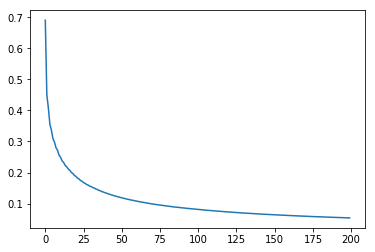

In [39]:
plt.plot(avg_loss_)

In [67]:
path_='omniglot_100_mod7_dataloader_ori.pth'
torch.save(model.state_dict(), path_)

In [30]:
model.load_state_dict(torch.load('omniglot_100_mod7_dataloader_ori.pth'))

In [51]:

batch_size=1

# data_transform = transforms.Compose([transforms.Resize(112),
#         transforms.CenterCrop(105),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))


dataset_att=att_dataset(main_dir='omniglot/train_/',data_transorm=data_transform_test,flag_train=True)
train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=batch_size,shuffle=True)

dataset_att2=att_dataset(main_dir='omniglot/train_/',data_transorm=data_transform_test,flag_train=False)
eval_loader = torch.utils.data.DataLoader(dataset_att2, batch_size=batch_size,shuffle=True)

965
965


tensor([[ 1.]])


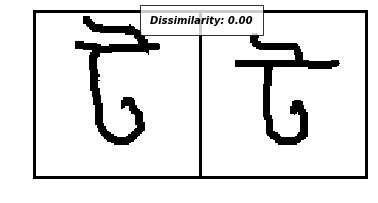

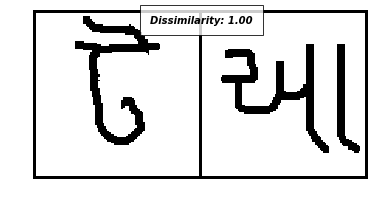

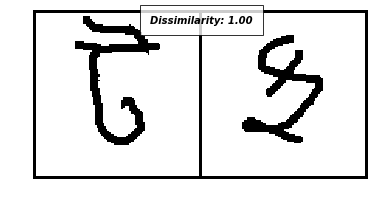

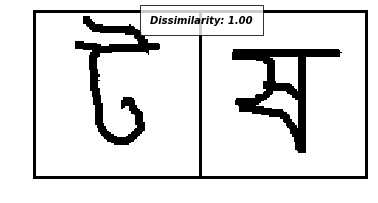

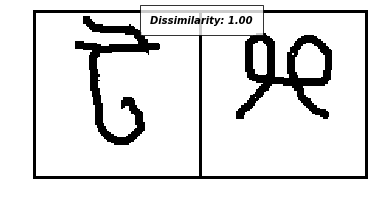

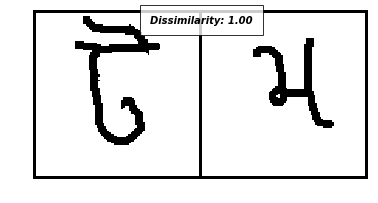

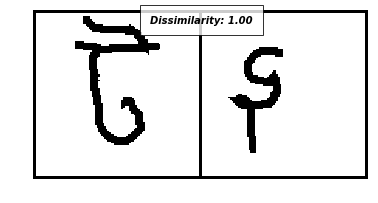

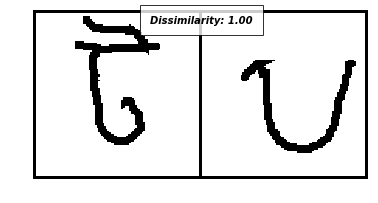

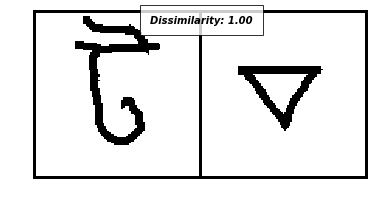

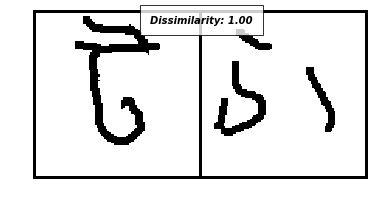

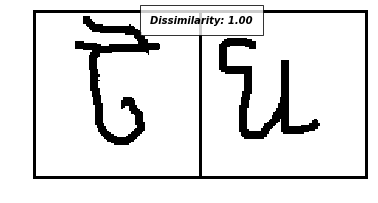

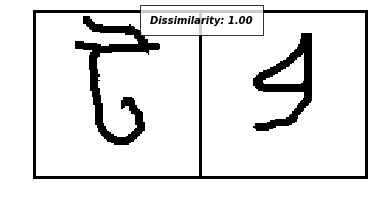

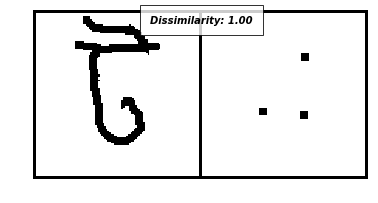

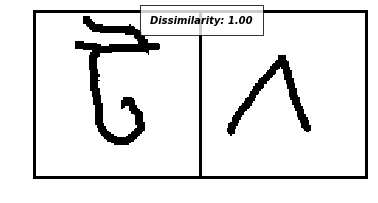

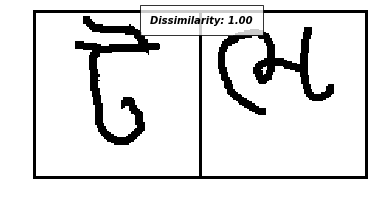

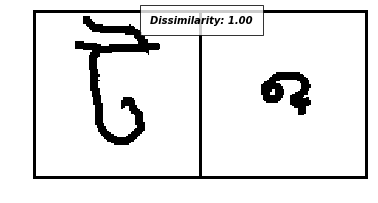

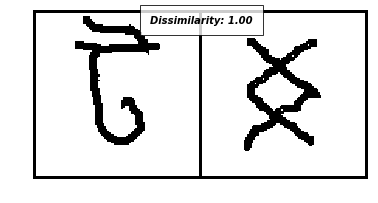

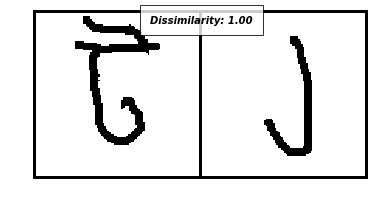

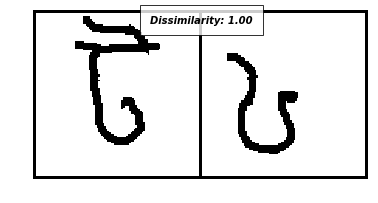

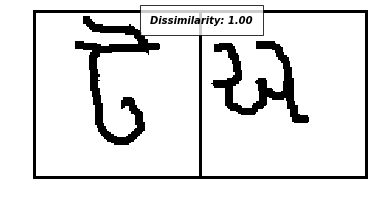

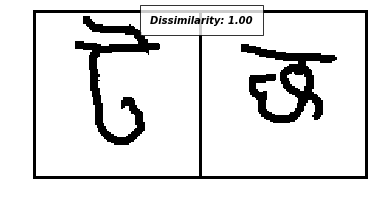

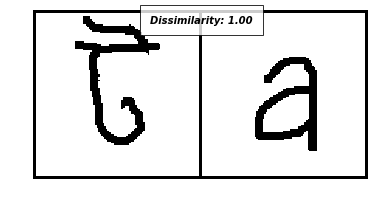

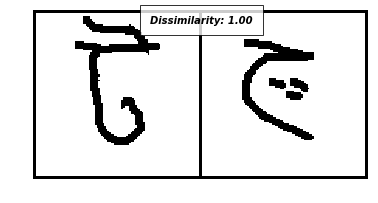

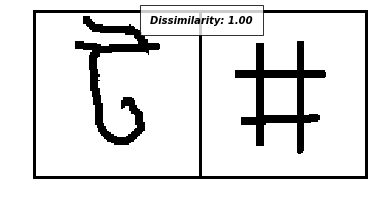

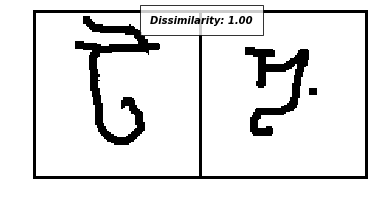

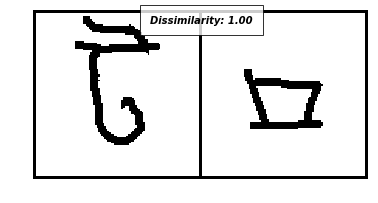

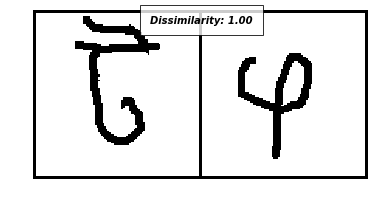

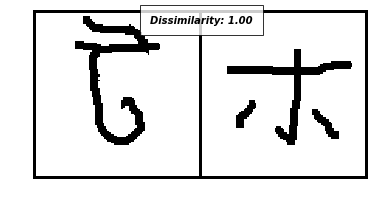

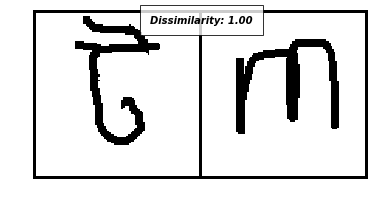

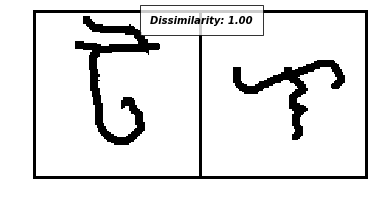

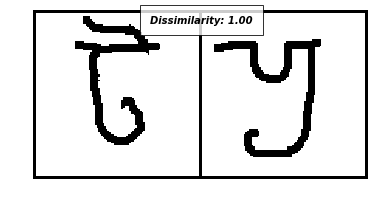

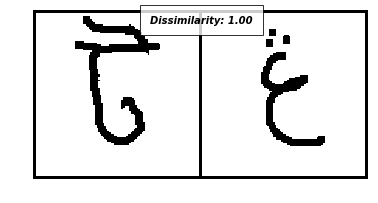

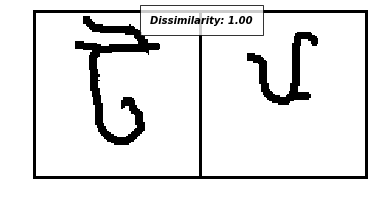

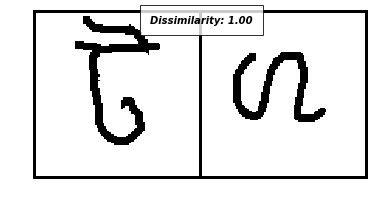

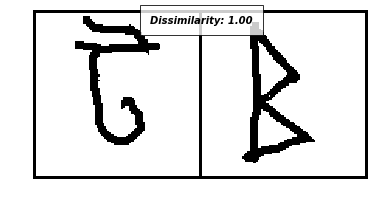

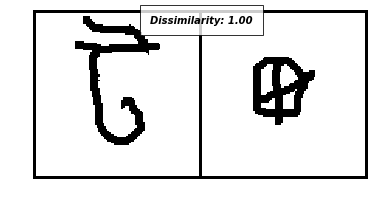

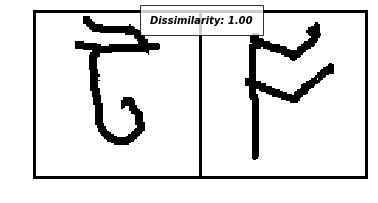

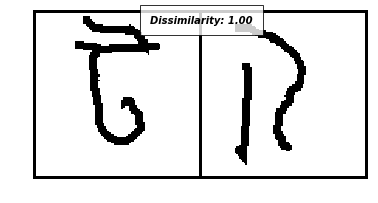

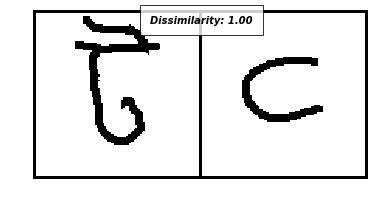

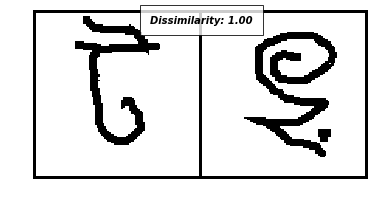

In [50]:

model.to(device)
with torch.no_grad():  

    dataiter = iter(eval_loader)
    flag=True
    
    while flag:
        
        img1,img2,labels = next(dataiter)
        #print(labels)
        if (int(labels.item())==1):       
            print(labels)
                        
            img1_tmp=img1
            img2_tmp=img2
            labels_tmp=labels
            flag=False

    

    #for step,(img1,img2,labels) in enumerate(train_loader):

    for i in range(40):
        
               
        if(i==0):        
            img1=img1_tmp
            img2=img2_tmp
            labels=labels_tmp
            
        if(i!=0):
            _,img2,labels = next(dataiter)
            

        model.eval()
        img1=img1.to(device)  #have to turnof device since weight saved not as cuda! after reloading saved model
        img2=img2.to(device)

        concatenated = torch.cat((img1,img2),0)
        #img1=img1.to(device)
        #img2=img2.to(device)
        labels=labels.to(device)

        output=model(img1,img2)   
        euclidean_distance = (1.0-F.sigmoid(output))  #substraction 4096 sigmoid  and then linear to 1 then sigmoid here
        loss=criterion(output,labels)    
        imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

tensor([[ 1.]])


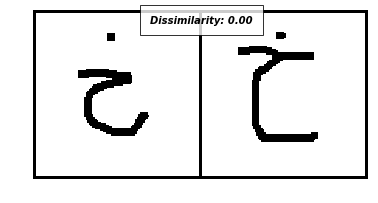

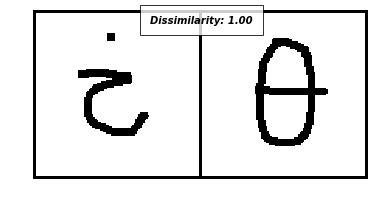

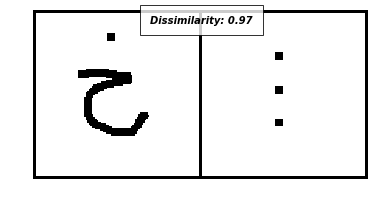

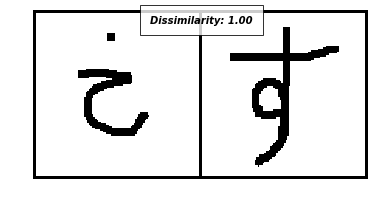

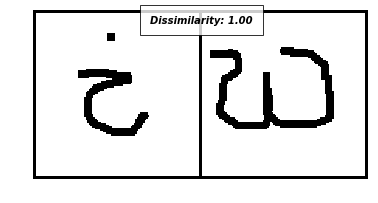

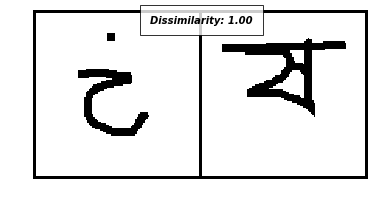

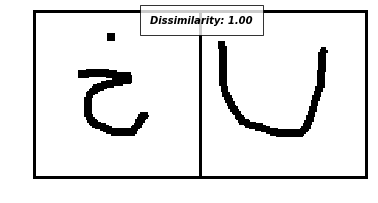

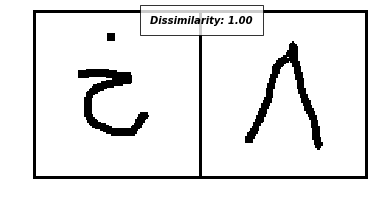

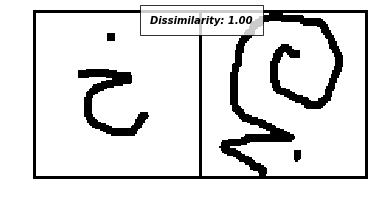

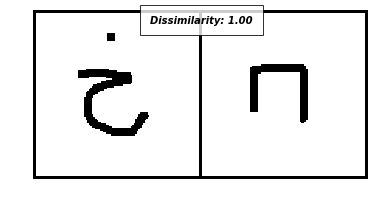

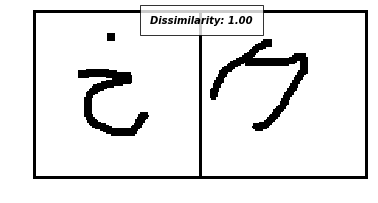

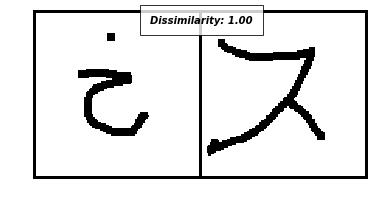

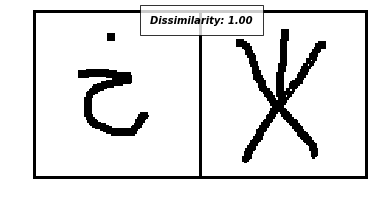

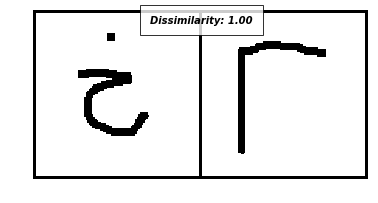

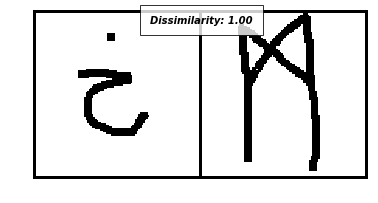

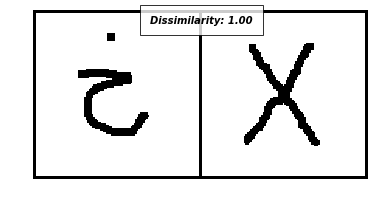

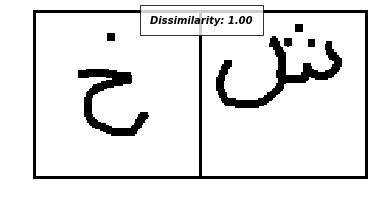

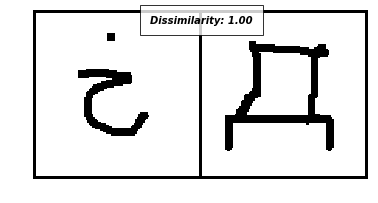

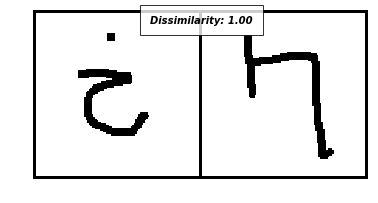

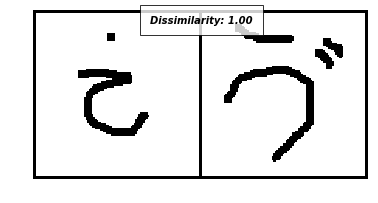

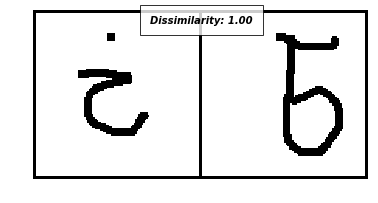

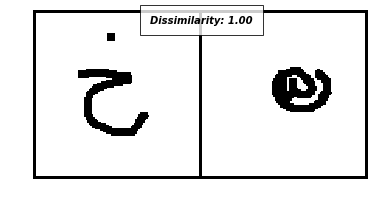

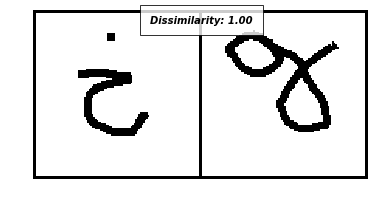

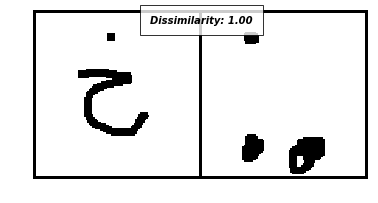

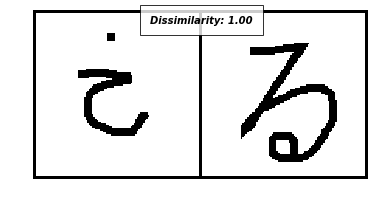

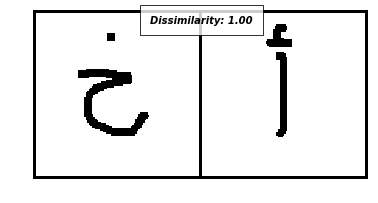

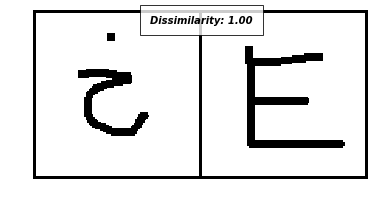

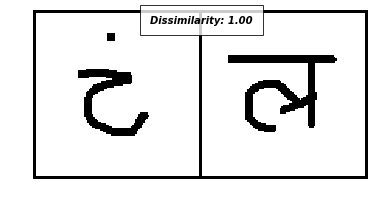

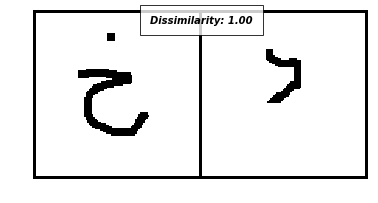

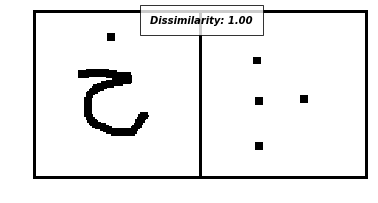

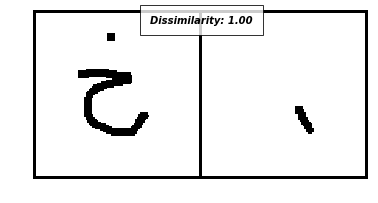

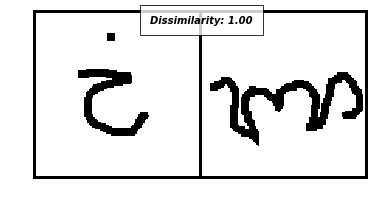

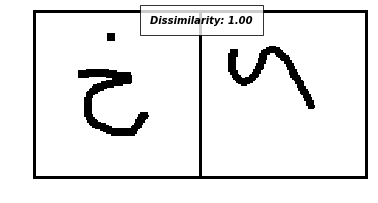

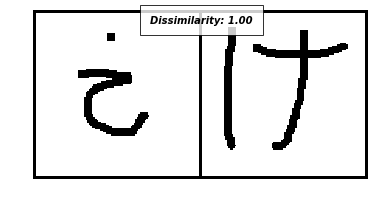

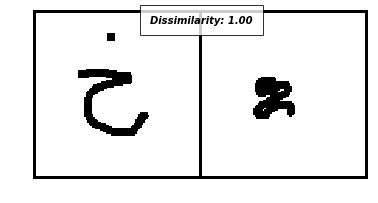

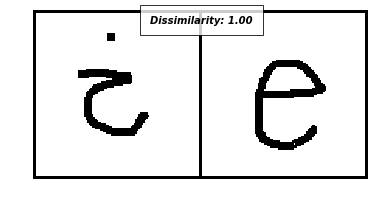

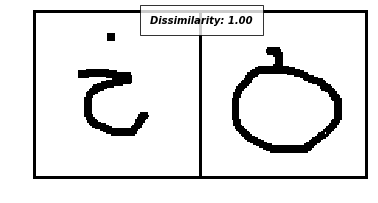

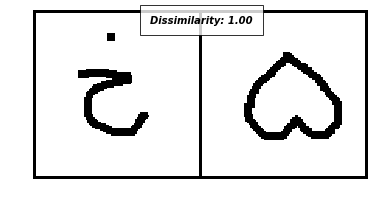

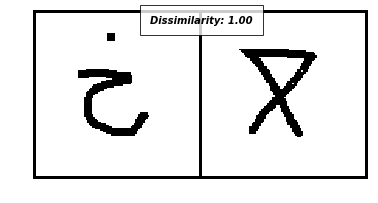

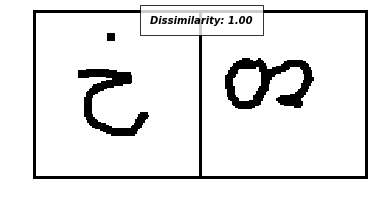

In [62]:

model.to(device)
with torch.no_grad():  

    dataiter = iter(train_loader)
    flag=True
    
    while flag:
        
        img1,img2,labels = next(dataiter)
        #print(labels)
        if (int(labels.item())==1):       
            print(labels)
                        
            img1_tmp=img1
            img2_tmp=img2
            labels_tmp=labels
            flag=False

    

    #for step,(img1,img2,labels) in enumerate(train_loader):

    for i in range(40):
        
               
        if(i==0):        
            img1=img1_tmp
            img2=img2_tmp
            labels=labels_tmp
            
        if(i!=0):
            _,img2,labels = next(dataiter)
            

        model.eval()
        img1=img1.to(device)  #have to turnof device since weight saved not as cuda! after reloading saved model
        img2=img2.to(device)

        concatenated = torch.cat((img1,img2),0)
        #img1=img1.to(device)
        #img2=img2.to(device)
        labels=labels.to(device)

        output=model(img1,img2)   
        euclidean_distance = (1.0-F.sigmoid(output))  #substraction 4096 sigmoid  and then linear to 1 then sigmoid here
        loss=criterion(output,labels)    
        imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [63]:

batch_size=1

# data_transform = transforms.Compose([transforms.Resize(112),
#         transforms.CenterCrop(105),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))



dataset_att3=att_dataset(main_dir='omniglot/test_/',data_transorm=data_transform_test,flag_train=False)
test_loader = torch.utils.data.DataLoader(dataset_att3, batch_size=batch_size,shuffle=True)

dataset_att4=att_dataset(main_dir='omniglot/test_/',data_transorm=data_transform_test,flag_train=True)
test_loader2 = torch.utils.data.DataLoader(dataset_att4, batch_size=batch_size,shuffle=True)

659
659


tensor([[ 1.]])


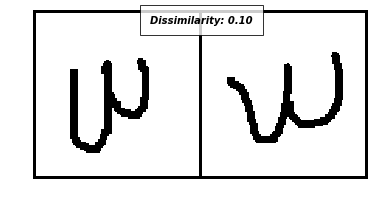

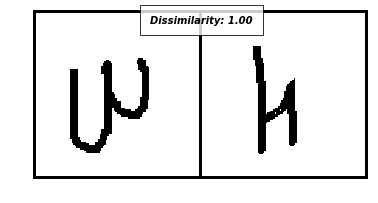

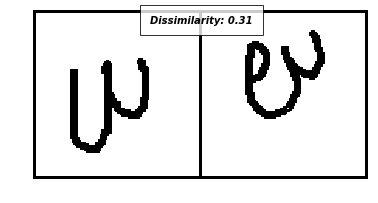

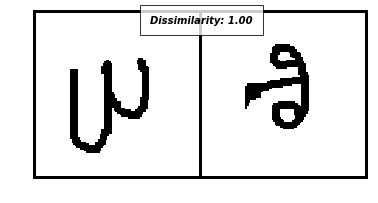

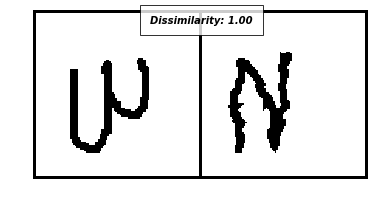

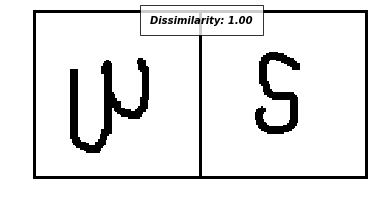

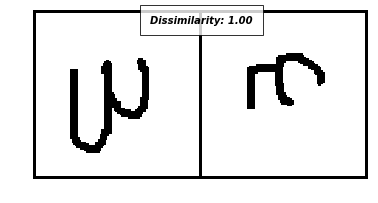

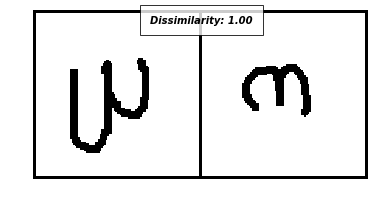

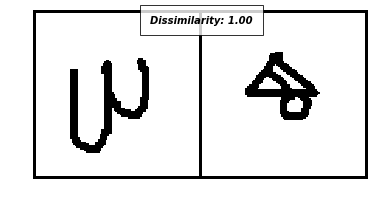

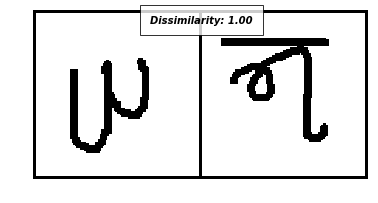

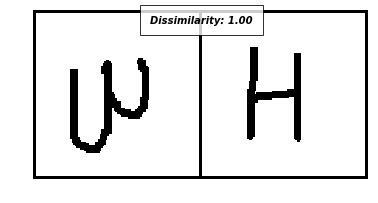

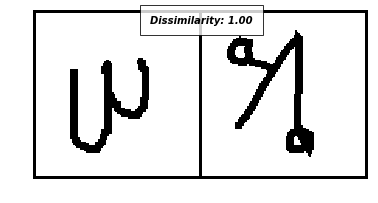

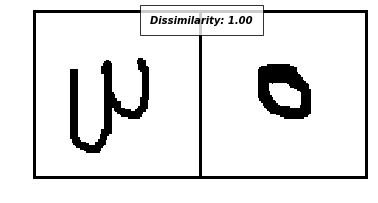

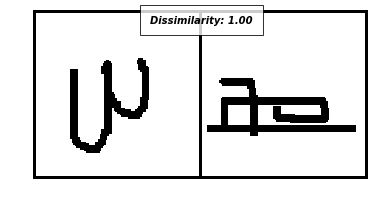

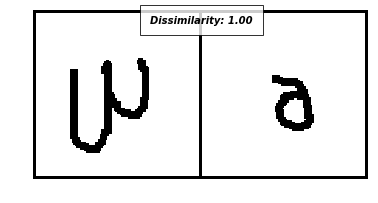

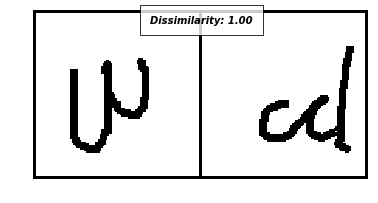

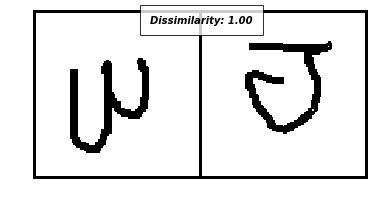

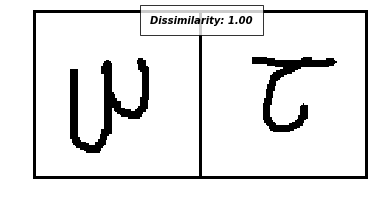

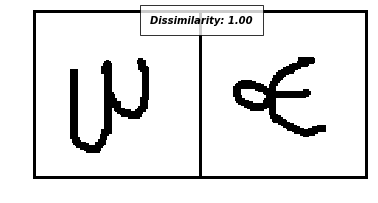

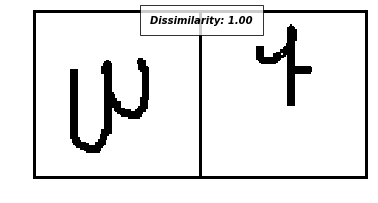

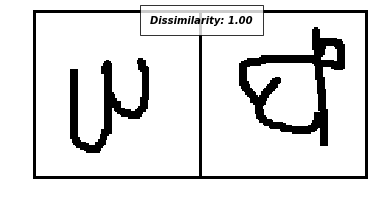

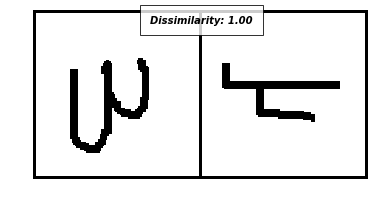

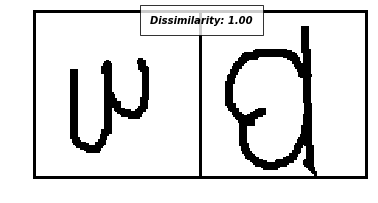

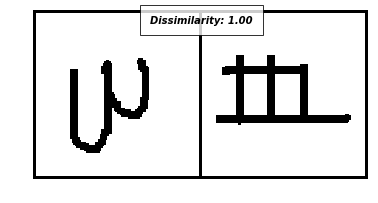

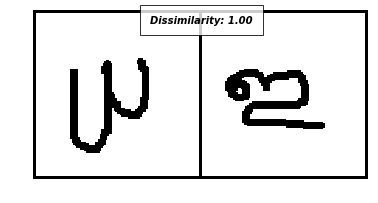

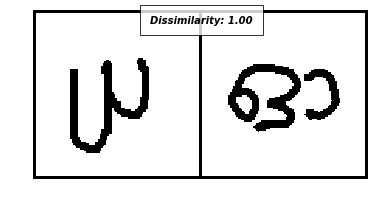

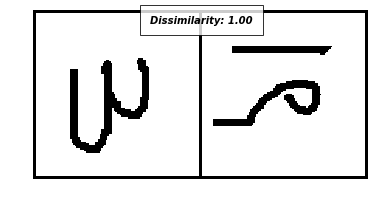

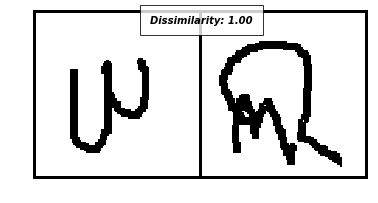

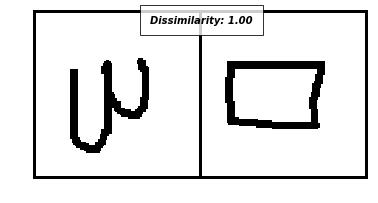

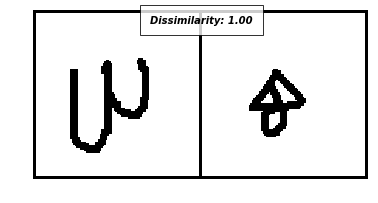

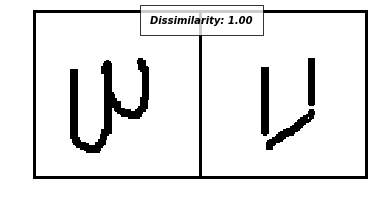

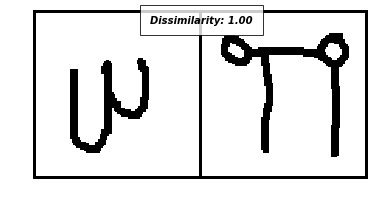

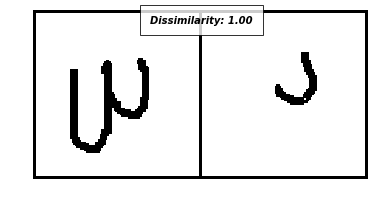

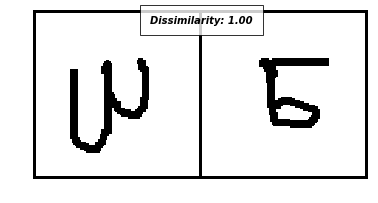

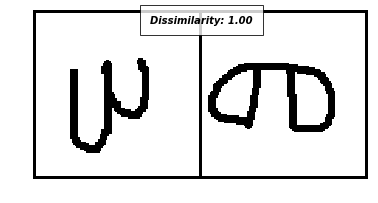

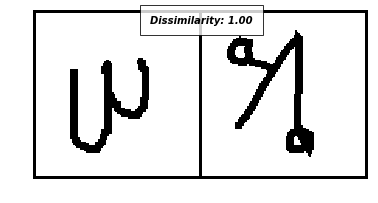

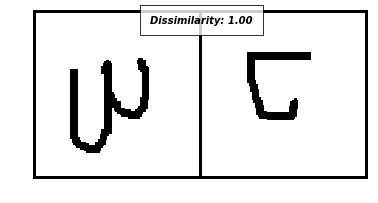

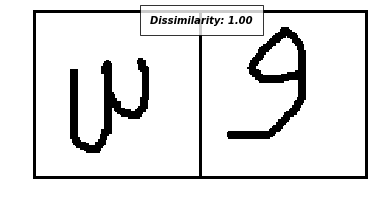

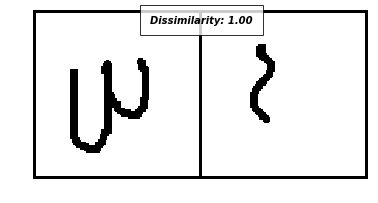

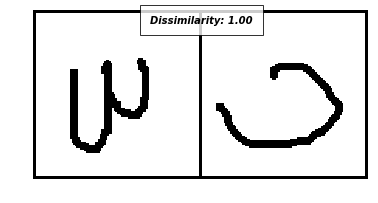

In [64]:

model.to(device)
with torch.no_grad():  

    dataiter = iter(test_loader)
    flag=True
    
    while flag:
        
        img1,img2,labels = next(dataiter)
        #print(labels)
        if (int(labels.item())==1):       
            print(labels)
                        
            img1_tmp=img1
            img2_tmp=img2
            labels_tmp=labels
            flag=False

    

    #for step,(img1,img2,labels) in enumerate(train_loader):

    for i in range(40):
        
               
        if(i==0):        
            img1=img1_tmp
            img2=img2_tmp
            labels=labels_tmp
            
        if(i!=0):
            _,img2,labels = next(dataiter)
            

        model.eval()
        img1=img1.to(device)  #have to turnof device since weight saved not as cuda! after reloading saved model
        img2=img2.to(device)

        concatenated = torch.cat((img1,img2),0)
        #img1=img1.to(device)
        #img2=img2.to(device)
        labels=labels.to(device)

        output=model(img1,img2)   
        euclidean_distance = (1.0-F.sigmoid(output))  #substraction 4096 sigmoid  and then linear to 1 then sigmoid here
        loss=criterion(output,labels)    
        imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

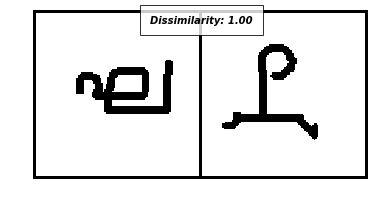

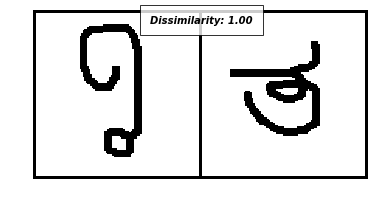

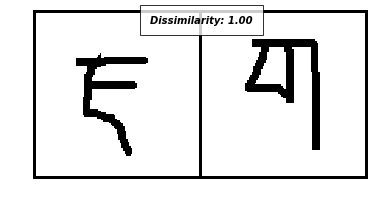

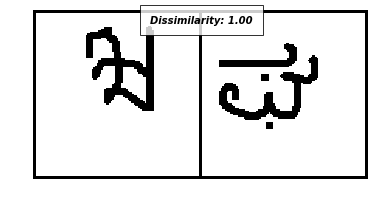

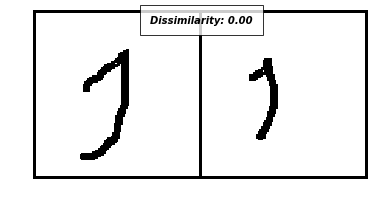

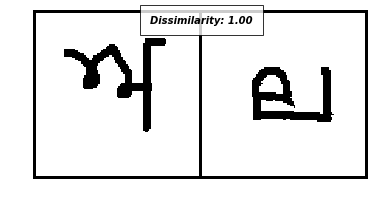

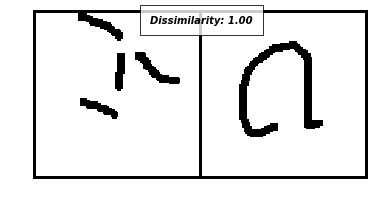

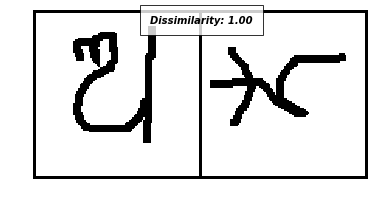

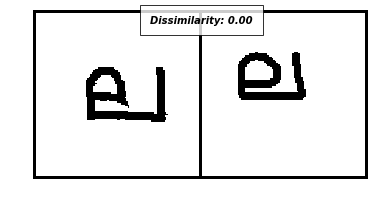

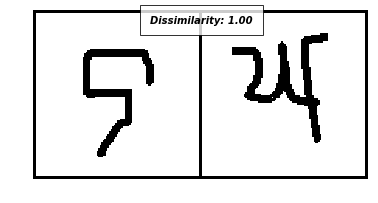

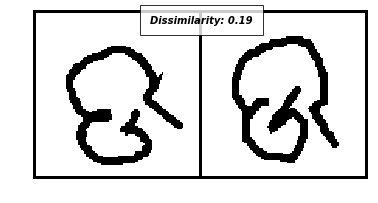

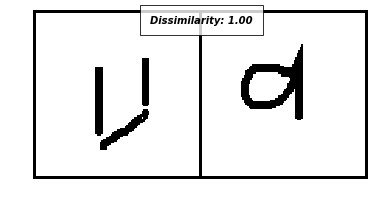

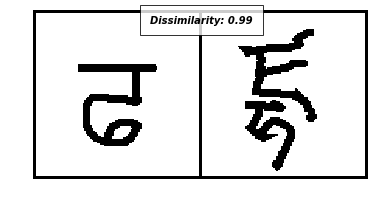

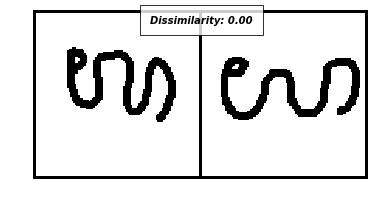

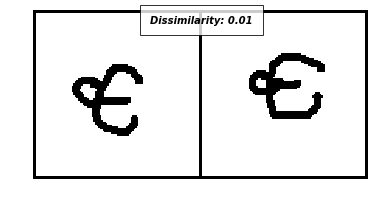

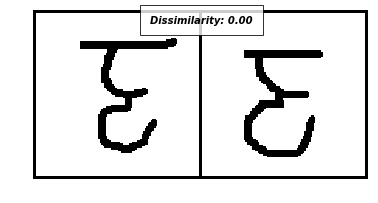

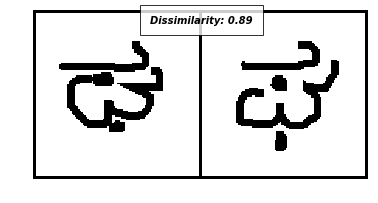

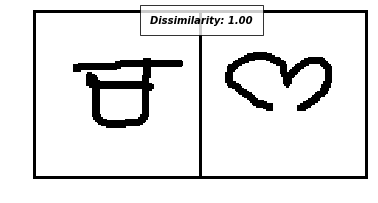

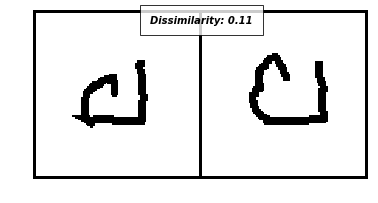

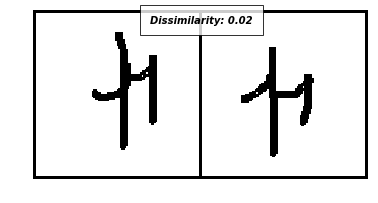

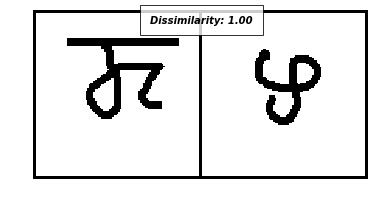

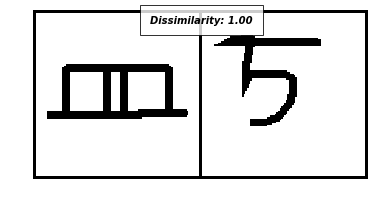

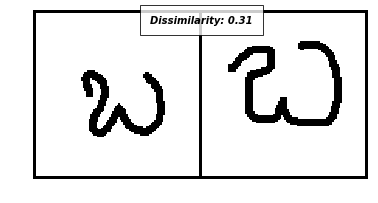

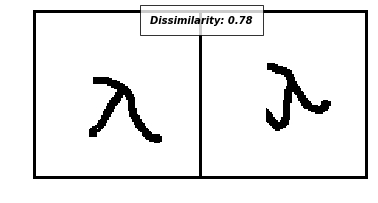

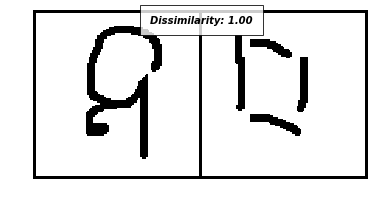

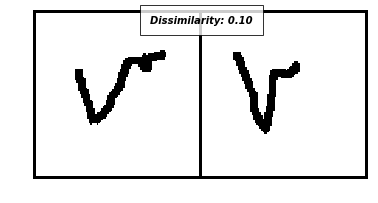

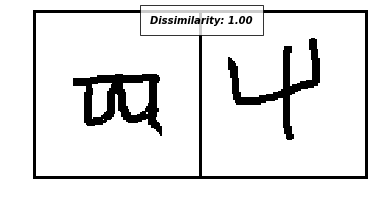

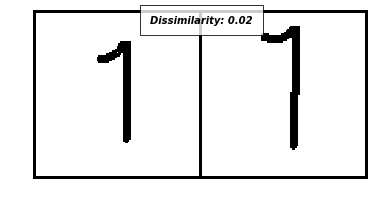

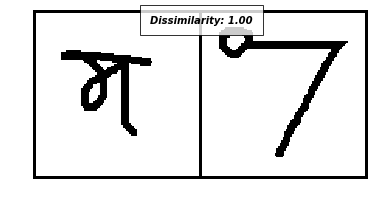

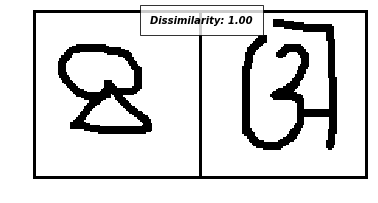

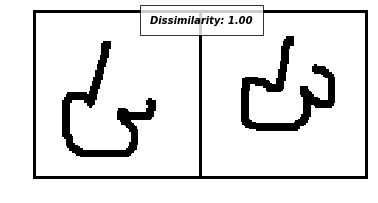

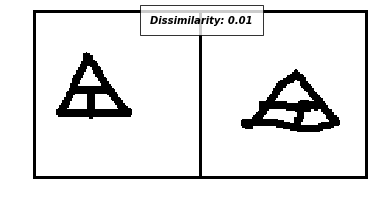

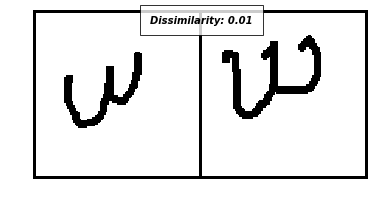

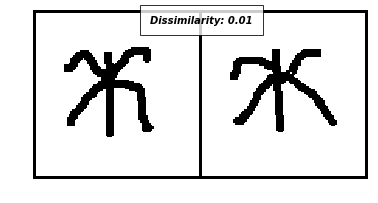

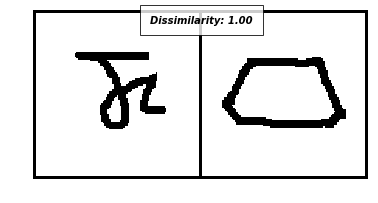

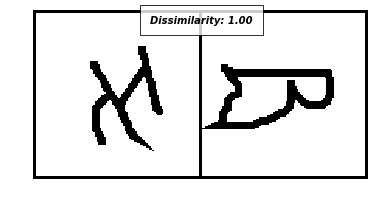

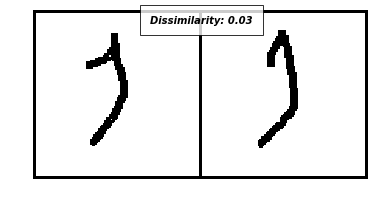

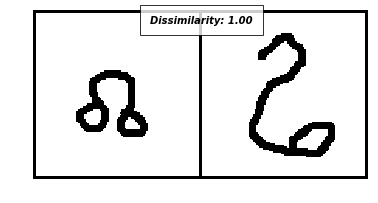

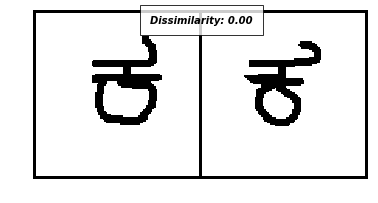

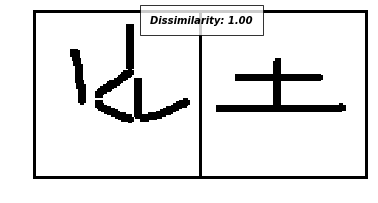

In [66]:

model.to(device)
with torch.no_grad():  

    dataiter = iter(test_loader2)
    flag=True
    
#     while flag:
        
#         img1,img2,labels = next(dataiter)
#         #print(labels)
#         if (int(labels.item())==1):       
#             print(labels)
                        
#             img1_tmp=img1
#             img2_tmp=img2
#             labels_tmp=labels
#             flag=False

    

#     #for step,(img1,img2,labels) in enumerate(train_loader):

    for i in range(40):
        
        img1,img2,labels = next(dataiter)   #just create pair to check with more similar samle with consistent
        
               
#         if(i==0):        
#             img1=img1_tmp
#             img2=img2_tmp
#             labels=labels_tmp
            
#         if(i!=0):
#             _,img2,labels = next(dataiter)
            

        model.eval()
        img1=img1.to(device)  #have to turnof device since weight saved not as cuda! after reloading saved model
        img2=img2.to(device)

        concatenated = torch.cat((img1,img2),0)
        #img1=img1.to(device)
        #img2=img2.to(device)
        labels=labels.to(device)

        output=model(img1,img2)   
        euclidean_distance = (1.0-F.sigmoid(output))  #   sigmois=1, means similar substraction 4096 sigmoid  and then linear to 1 then sigmoid here
        loss=criterion(output,labels)    
        imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [39]:
count=0
countj=0

for j in range(50):
    countj=countj+1
    print('--------------------------')
    dataiter = iter(train_loader)
    img1,_,_ = next(dataiter)
    distance_init=100.0
    label_save=None

    #for step,(img1,img2,labels) in enumerate(train_loader):
    with torch.no_grad():    
        for i in range(50):

            _,img2,labels = next(dataiter)

            model.eval()
            img1=img1.to(device)
            img2=img2.to(device)

            concatenated = torch.cat((img1,img2),0)
            #img1=img1.to(device)
            #img2=img2.to(device)
            labels=labels.to(device)

            output1,output2=model(img1,img2)   
            euclidean_distance = F.pairwise_distance(output1, output2)
            loss=criterion(output1,output2,labels)
            if(euclidean_distance<distance_init): 
                distance_init=euclidean_distance
                label_save=labels.item()
                
               
            #imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
        if(label_save==1): count=count+1
            
print(count*100./countj)            

--------------------------


KeyboardInterrupt: 